개선점: 
1. 오프라인에서도 작동하도록.
2. 데이터 얼굴 crop 귀까지 온전하게
3. 이미지 resize된 얼굴 샘플링에서 제외
4. FaceNet input으로 들어가는 이미지 사이즈는?
5. 선택 후 딜레이가 길다.
6. Cluster 샘플링이 필요하다.

# 0. Intro

### 기능 설명
- 이상형은 가장 평균적인 이목구비 + 기억에 의해 결정됩니다. 때문에 성격을 고려하지 않고도, 이상형을 고를 수 있습니다. 또한, 이미지를 합성할 수록 평균적인(매력적인) 이목구비에 가까워지고, 매력적이라고 느끼는 이미지를 합성하면 더욱 더 이상형에 가까운 이미지를 생성한다고 합니다. 이러한 원리를 이용하여 만든 이상형 학습 알고리즘입니다.
- Cluster를 좁혀가는 방법이 아닌, 선택한 이미지들의 평균 Feature Embedding을 구하고, 가까운 Dist를 가지는 이미지를 출력해주는 방법입니다.

### 작동 방식
1. Sampling: 난수 index를 생성하여 선택지를 만듭니다.
2. 선택: 선택지 이미지를 사용자에게 주어주고, 좋아하는 이상형을 고르도록 합니다.
3. 이상형 feature 계산: 고른 이미지들의 평균 feature값을 이용하여 이상형 feature를 구합니다.
4. 가까운 Dist를 가진 Image 출력: 선택한 이미지를 제외한 이미지 중에서 가장 가까운 Dist를 가지는 이미지를 출력합니다.(본 코드에서는 Euclidean 거리를 사용하였습니다.)

### 결과 및 한계점
- 선택 문항, 횟수를 늘릴 수록 더 정확해지는 것으로 보입니다.
- 본 결과만으로도 대체적으로 좋은 결과가 나오지만(데이터가 너무 예쁘고, 잘생긴 사람들이 많은 것일 수도...), 무작위 샘플링이 이루어지기 때문에, 어느 정도 오차가 존재하는 것 같습니다. => 기존의 Cluster를 이용한 Sampling 방법으로 보완하면 좋겠다는 생각이 듭니다!

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

%matplotlib inline

# 1. 변수 설정

In [2]:
# 얼굴 데이터와 feautre가 존재하는 path
data_path = '/Users/ibird/DL_Data/이상형'

In [3]:
# 이상형의 성별
sex = 'female'

# 선택 횟수
num_choice_set = 15

# 선택지 개수
num_choice = 7

# feature normalize?
norm_flg = True

# 이상형 결과에 선택한 이미지 제외 또는 포함 flg
overlap_flg = False

In [4]:
# 얼굴 데이터와 Feature 불러오기
if sex == 'male':
  datas = np.load(os.path.join(data_path, 'female_not_resized_faces.npz'), allow_pickle=True)['arr_0']
  fts = pd.read_csv(os.path.join(data_path, 'df_female_embeddings_test_dgkim.csv')).drop(columns='Unnamed: 0')
else:
  datas = np.load(os.path.join(data_path, 'male_not_resized_faces.npz'), allow_pickle=True)['arr_0']
  fts = pd.read_csv(os.path.join(data_path, 'df_male_embeddings_test_dgkim.csv')).drop(columns='Unnamed: 0')

In [5]:
wmn_datas = np.load(os.path.join(data_path, 'female_not_resized_faces.npz'), allow_pickle=True)['arr_0']
wmn_fts = pd.read_csv(os.path.join(data_path, 'df_female_embeddings_test_dgkim.csv')).drop(columns='Unnamed: 0')
man_datas = np.load(os.path.join(data_path, 'male_not_resized_faces.npz'), allow_pickle=True)['arr_0']
man_fts = pd.read_csv(os.path.join(data_path, 'df_male_embeddings_test_dgkim.csv')).drop(columns='Unnamed: 0')

In [6]:
man_fts

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,1.421740,-1.624540,-0.193522,-0.497583,0.819527,-1.380966,-0.117000,0.414923,-1.227084,0.827050,...,0.542256,-1.197777,1.030178,0.432860,-0.417912,0.847210,0.040934,-1.338224,-0.842738,-1.417311
1,0.054608,-2.018462,-0.369199,-0.306852,-0.457197,-1.085720,1.311089,1.141802,-0.656438,0.215786,...,-1.161283,-1.171264,1.375616,1.787035,-0.113234,0.598401,-1.085675,-1.267216,-0.412683,-1.056034
2,1.481933,-1.685566,0.899287,-0.489774,0.893384,-2.164528,-0.646191,-0.427387,-0.504949,-1.206712,...,0.712546,0.196884,0.287512,-1.320548,0.084912,-0.102669,0.144486,-1.403712,-0.346037,0.380640
3,1.451488,-0.403122,-1.830624,0.833423,0.827568,-0.984413,-0.112817,1.547332,1.131718,-0.054477,...,-0.199246,-0.573929,-0.198216,-0.393829,-0.009916,1.509837,-0.069093,-1.634165,-0.693172,-1.192988
4,-1.050296,-0.723957,-0.771146,1.735189,1.327748,-1.960780,0.702037,-0.711626,-0.119967,-1.270364,...,0.784342,0.758736,-0.780222,0.927796,0.962574,-0.967376,0.377765,-1.330802,0.097961,0.082626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,0.224386,-0.495185,0.358724,0.696791,1.929666,-1.371947,1.175422,-0.327014,-0.905985,0.212716,...,-0.128546,-0.382062,-0.001279,-0.822616,-0.342263,-0.292784,-1.043796,-2.502810,-0.873512,-0.851493
656,1.501094,-0.089584,-0.563319,-0.103563,-0.293987,1.050444,-0.037083,-0.176863,0.917293,-0.175884,...,0.390242,0.296602,0.653424,-0.313427,-0.553058,1.149894,0.202786,-2.363487,-1.150281,-0.548201
657,0.053023,0.094071,0.341872,-0.312237,-1.590409,-0.505040,-0.610238,-0.763083,-1.760753,-0.064512,...,0.059520,0.264391,1.437974,0.118686,0.380895,0.847918,0.868019,-1.637699,0.767209,-1.189795
658,0.567825,-0.992398,0.367867,0.289247,-0.661290,-1.484840,0.135643,-0.405305,-0.373244,0.703768,...,-0.921019,0.387602,0.708791,-0.086746,0.438397,0.205028,0.026493,-2.583763,-0.551827,-1.314604


In [ ]:
for i, data in enumerate(datas):
    img = Image.fromarray(data)
    index = str(i).zfill(4)
    img.save(f"/Users/ibird/DL_Data/이상형/image/{index}.png")

In [7]:
if norm_flg:
  from sklearn.preprocessing import normalize
  fts = pd.DataFrame(normalize(fts))

# 2. 이미지 선택

## 이미지 Sampling을 위한 난수 생성
이 Sampling부분을 손을 봐야할 것 같습니다.  
선택 횟수가 늘어날 수록 더 정확해집니다.  

In [8]:
# 난수를 생성하고 선택지, 문항 수에 따라 reshape합니다.
random_index = np.random.choice(datas.shape[0], 
                                num_choice_set * num_choice, replace=False)
random_index = random_index.reshape((num_choice_set, num_choice))
random_index.shape

(15, 7)

## 이미지를 선택합니다
왼쪽부터 1번으로 시작합니다. your choice에 번호를 넣고 enter를 눌러주시면 됩니다.

#### choices = []
for idx, index_set in enumerate(random_index):
  fig = plt.figure(figsize=(50, 50))
  plot_idx = 1
  for i, index in enumerate(index_set):
    fig.add_subplot(1, len(index_set), plot_idx)
    plt.axis('off')
    plt.imshow(datas[index])
    plot_idx += 1
  plt.show()
  plt.close(fig)
  
  turn = str(idx+1) + '/' + str(num_choice_set)
  choice = list(map(lambda x: int(x)-1, input(turn + '\tyour choice: ').split()))
  while not set(choice).issubset(range(len(index_set))):
    choice = list(map(lambda x: int(x)-1, input(turn + '\twrong number. your choice: ')))
  choices += list(map(lambda x: index_set[x], choice))


print('Go Next Step!')

#### 3. 평균 Feature Embedding 계산

In [66]:
# 고른 얼굴의 평균 embedding 계산합니다.
choice_fts = fts.iloc[choices]
choice_avg = np.average(choice_fts, axis=0)
choices, choice_avg.shape

([653, 272, 249, 654, 475, 198, 410, 564], (128,))

In [67]:
# 선택한 얼굴을 제외한 나머지 얼굴 feature를 불러옵니다.
if overlap_flg:
  for_result_fts = fts
else:
  for_result_fts = fts.drop(index=choices)
  for_result_fts.index = for_result_fts.index.astype(int)

In [68]:
choice_avg

array([ 8.22356585e-02, -4.53730082e-02, -3.60583619e-02, -1.54470785e-02,
        7.44236816e-03, -8.23608012e-02, -6.18793862e-02, -2.95719682e-02,
        3.91820927e-02,  6.10983439e-03, -6.46425050e-02, -1.24962398e-01,
       -1.33831256e-01, -7.69692270e-03,  2.59509536e-02, -4.17793562e-02,
        2.34832447e-02,  6.86195135e-02, -3.16681688e-02, -8.98720848e-02,
       -5.95560243e-02,  8.83136799e-03, -5.18096075e-02,  6.64356418e-02,
        8.24603661e-02,  2.01119915e-02, -6.05785467e-03,  1.70104476e-02,
       -4.56321240e-03,  2.87313202e-02,  6.88036010e-02,  6.89153530e-02,
       -9.27298363e-03,  2.47008552e-02,  9.20743251e-03, -5.44475423e-02,
        3.36195681e-02,  3.50374864e-02,  5.13247890e-02,  1.95000977e-02,
        6.03349103e-02, -3.13261868e-02, -2.76851024e-02,  1.58960995e-02,
       -2.79919140e-02, -6.07664122e-03,  2.12803642e-02, -1.24624460e-02,
        1.28242237e-04, -2.38985620e-02,  8.76697601e-03, -3.06694402e-02,
       -8.94033302e-03, -

# 4. 가까운 dist를 가진 이미지 출력

## 나머지 feature들을 불러와 choice_fts와 거리를 계산합니다.

In [69]:
# euclidean 거리를 사용하여 embedding 간의 거리를 계산합니다.

from sklearn.neighbors import DistanceMetric
get_dist = DistanceMetric.get_metric('euclidean')

distances = [] # [embedding 거리, 이미지 index]를 담습니다.
for idx in for_result_fts.index:
  ft = for_result_fts.loc[idx]
  dist = get_dist.pairwise([choice_avg, ft])[0, 1]
  distances.append([dist, idx])

In [70]:
# embedding 거리를 기준으로 정렬됩니다.
sorted_dist = sorted(distances)

## 가장 이상형에 가까운 이미지를 출력합니다.

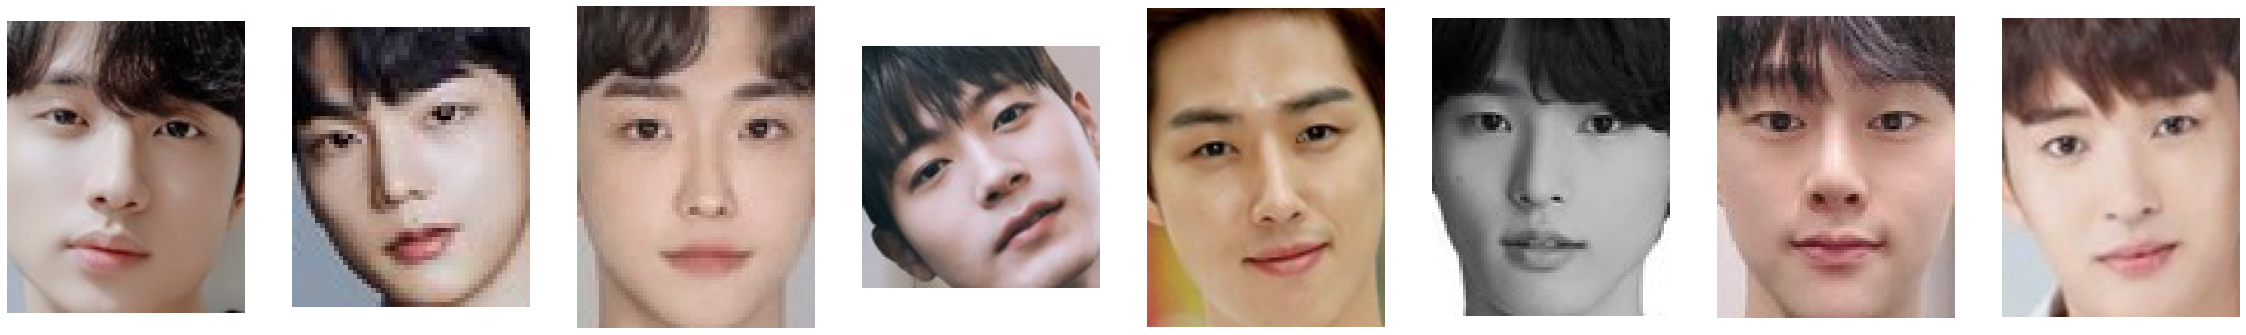

In [71]:
# 출력할 이미지 개수
num_best = 8

fig = plt.figure(figsize=(40, 40))
plot_idx = 1
for i in range(num_best):
  fig.add_subplot(1, num_best, plot_idx)
  plt.axis('off')
  plt.imshow(datas[sorted_dist[i][1]])
  plot_idx += 1
plt.show()

## 이상형과 거리가 먼 이미지를 출력합니다.

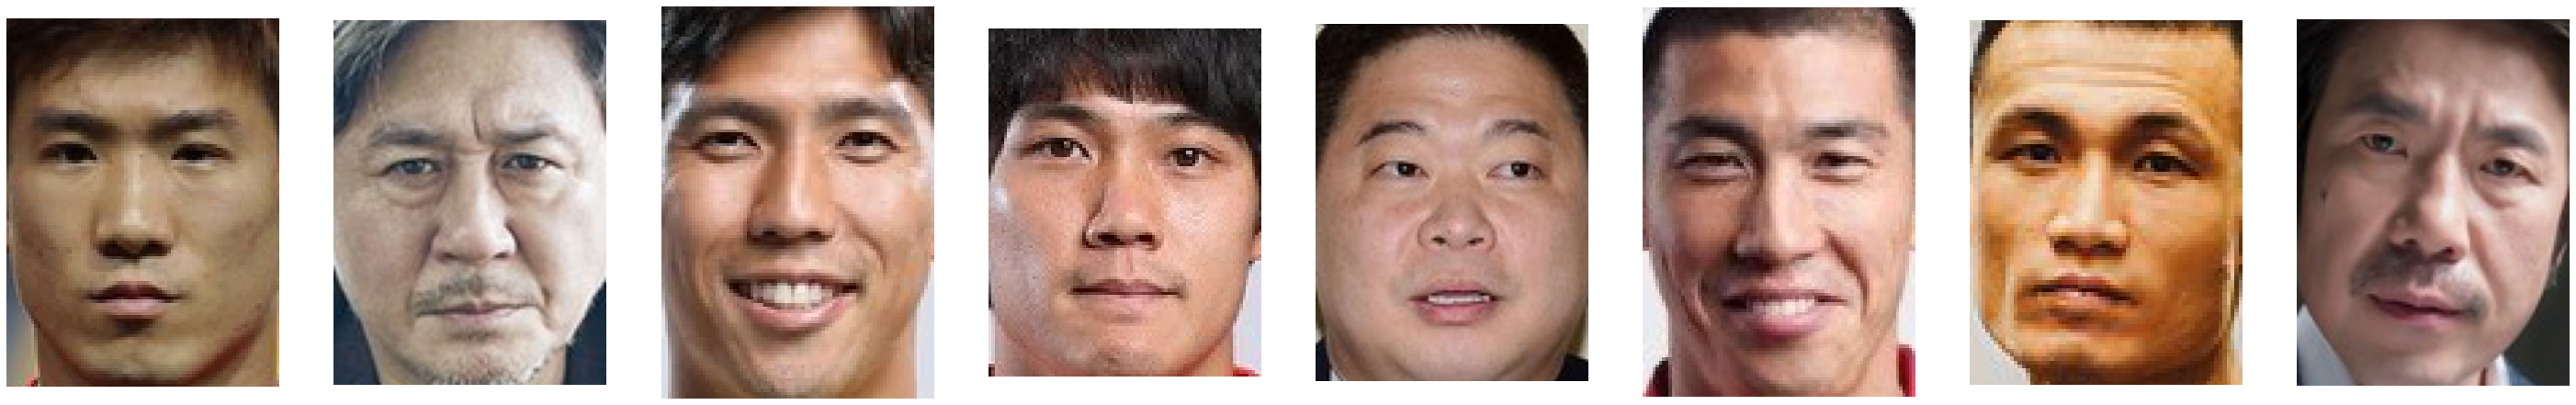

In [72]:

fig = plt.figure(figsize=(50, 65))
plot_idx = 1
for i in range(num_best):
  fig.add_subplot(1, num_best, plot_idx)
  plt.axis('off')
  plt.imshow(datas[sorted_dist[-i-1][1]])
  plot_idx += 1
plt.show()
